Libraries

In [1]:
import pandas as pd
import gc
import json
import datetime as dt
from pytz import timezone
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from yellow import trips as yt
from yellow import plots

Trips

In [2]:
trips = pd.read_csv('~/saida.csv')
print(len(trips), 'trips')

427026 trips


Filters

In [3]:
stats = pd.read_csv('~/traj-stats.csv')
intersects = pd.read_csv('~/streets-coverage.csv')
filtered = trips.merge(stats, on='tripid').merge(intersects, on='tripid')
filtered = filtered[(filtered.total_distance >= 50) & (filtered.total_distance <= 10000) &
                    (filtered.total_duration >= 60)]
filtered['start_time'] = yt.extract_start_times(trips)
print(len(filtered), 'trips')

223307 trips


**The strange pattern:** there is a horizontal line in `take_time_max` plot

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


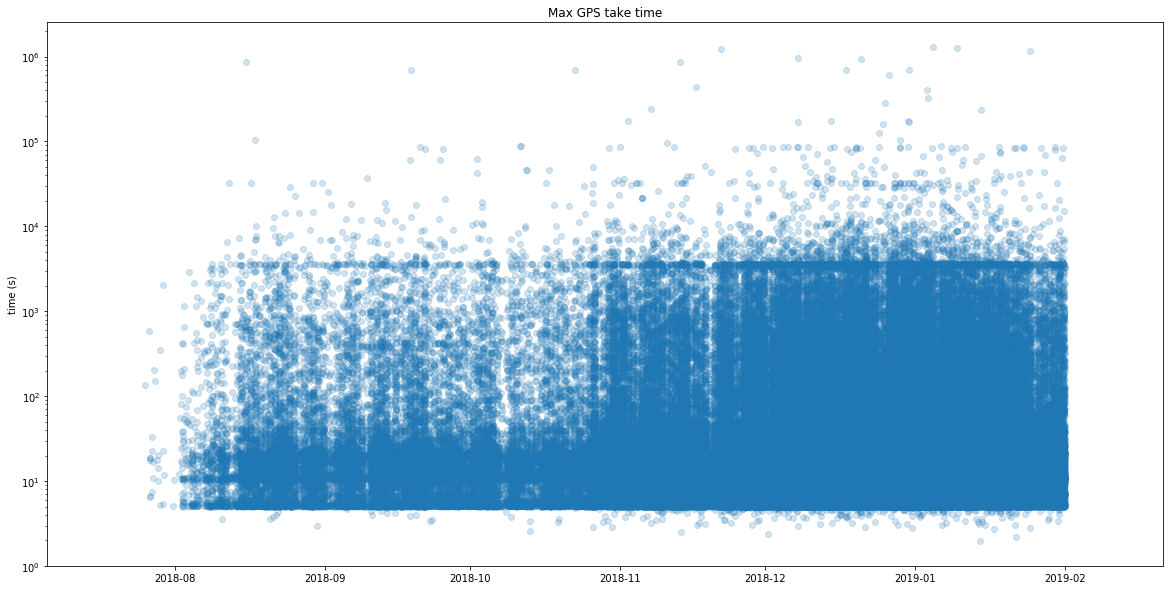

In [4]:
plt.figure(figsize=(20, 10))
plots.log_scale(y=True)
plots.time_scatter(filtered.take_time_max, 'Max GPS take time', 'time (s)', filtered.start_time)
plt.show()

Capturing the line

In [5]:
selected = filtered[(filtered.take_time_max > 1000) & (filtered.take_time_max < 5000)]
plt.hist(selected.take_time_max, bins=500)
plt.show()

In [6]:
selected = filtered[(filtered.take_time_max > 3000) & (filtered.take_time_max < 4000)]
selected['discrete_ttm'] = selected.take_time_max // 100
freqs = selected.groupby('discrete_ttm', as_index=False).agg({'tripid': 'count'})
freqs.columns = ['discrete_ttm', 'freq']
freqs.discrete_ttm *= 100
freqs

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


discrete_ttm  freq
0        3000.0   139
1        3100.0   164
2        3200.0   143
3        3300.0   155
4        3400.0   163
5        3500.0   997
6        3600.0   271
7        3700.0    89
8        3800.0    64
9        3900.0    60

Here we go!

In [7]:
filtered = filtered[(filtered.take_time_max >= 3500) & (filtered.take_time_max < 3600)]

Trips per day

In [8]:
filtered['date'] = filtered.start_time.dt.to_period('d').dt.to_timestamp()
trips_per_day = filtered.groupby('date', as_index=False).agg({'tripid': 'count'})
trips_per_day.columns = ['date', 'trip_count']
plt.figure(figsize=(20, 10))
plt.ylabel('# trips')
plt.plot(trips_per_day.date, trips_per_day.trip_count)
plt.show()

Basic overview 

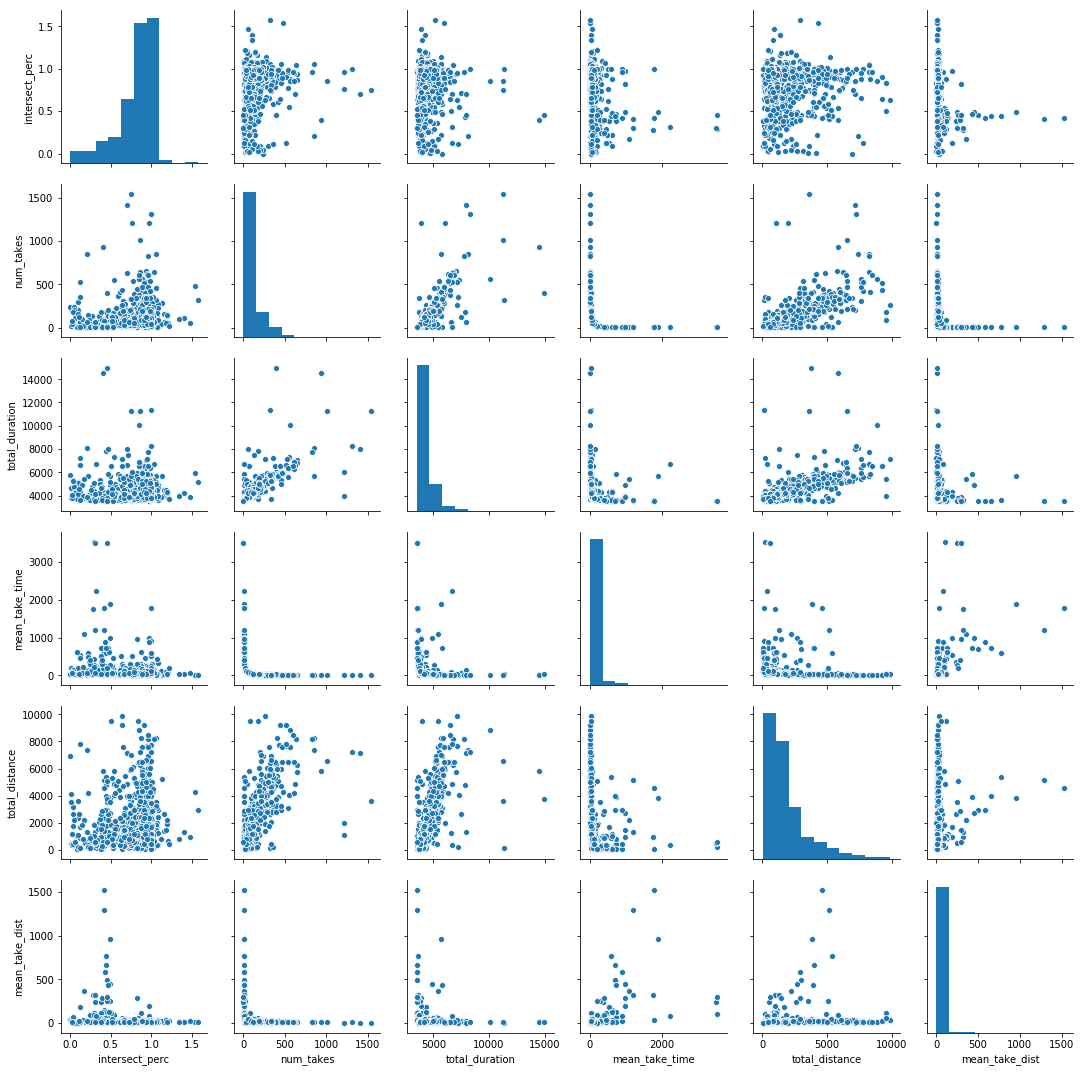

In [9]:
stats_columns = [
         'num_takes', 
         'total_duration', 'mean_take_time',
         'total_distance', 'mean_take_dist',
]
sns.pairplot(filtered[['intersect_perc'] + stats_columns])

Trajectory statistics

GPS takes


count     997.000000
mean      123.092277
std       149.067764
min         2.000000
25%        46.000000
50%        79.000000
75%       142.000000
max      1538.000000
Name: num_takes, dtype: float64

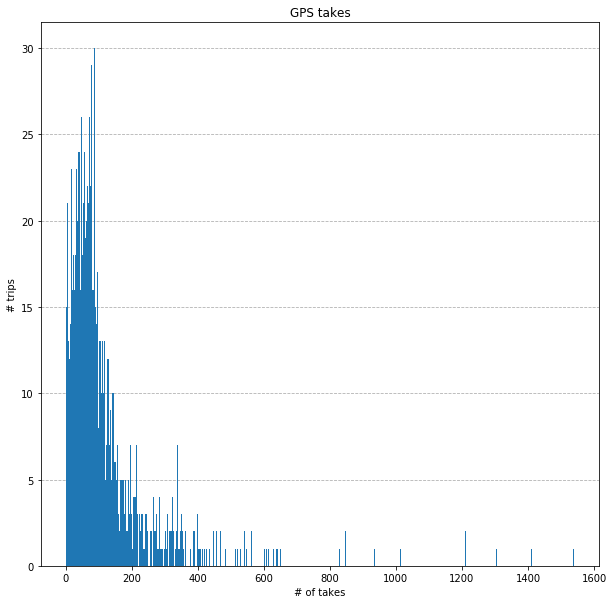

In [10]:
title = 'GPS takes'
print(title)
stat = filtered.num_takes
display(stat.describe())
plt.figure(figsize=(10, 10))
#plots.log_scale(x=True, y=True)
plots.dist_chart(stat, title, '# of takes')
plt.show()

In [11]:
title = 'Trip duration'
print(title)
stat = filtered.total_duration / 60
display(stat.describe())
plt.figure(figsize=(10, 10))
#plots.log_scale(x=True, y=True)
plots.dist_chart(stat, title, 'duration (minutes)')
plt.show()

Trip duration


count    997.000000
mean      72.078981
std       15.665958
min       58.407167
25%       64.283917
50%       67.456317
75%       74.229050
max      249.206583
Name: total_duration, dtype: float64

In [12]:
title = 'Mean GPS take time'
print(title)
stat = filtered.mean_take_time
display(stat.describe())
plt.figure(figsize=(10, 10))
#plots.log_scale(x=True, y=True)
plots.dist_chart(stat[stat < 100], title, 'times (s)')
plt.show()

Mean GPS take time


count     997.000000
mean      109.673334
std       264.250597
min         3.243564
25%        31.700544
50%        51.966506
75%        87.572256
max      3534.225000
Name: mean_take_time, dtype: float64

Min GPS take time


count     997.00000
mean       13.72653
std       192.64028
min         0.00100
25%         1.00200
50%         4.27000
75%         4.63100
max      3534.22500
Name: take_time_min, dtype: float64

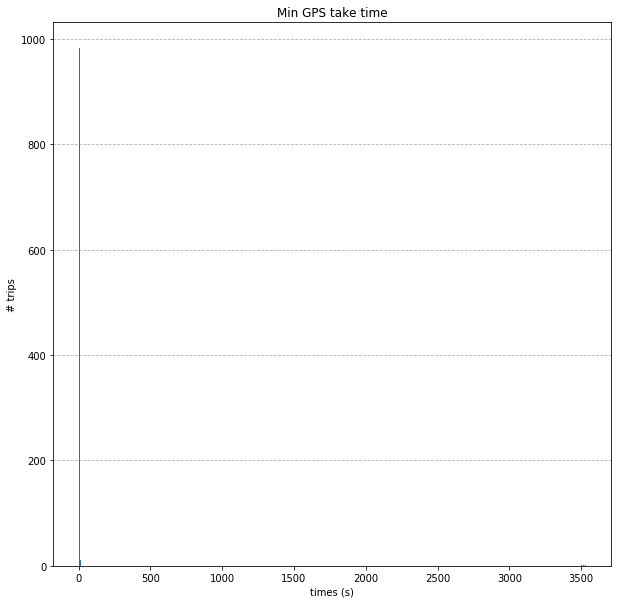

In [13]:
title = 'Min GPS take time'
print(title)
stat = filtered.take_time_min
display(stat.describe())
plt.figure(figsize=(10, 10))
#plots.log_scale(x=True, y=True)
plots.dist_chart(stat, title, 'times (s)')
plt.show()

Max GPS take time


count     997.000000
mean     3561.475328
std        22.968749
min      3500.179000
25%      3546.836000
50%      3562.157000
75%      3579.654000
max      3599.934000
Name: take_time_max, dtype: float64

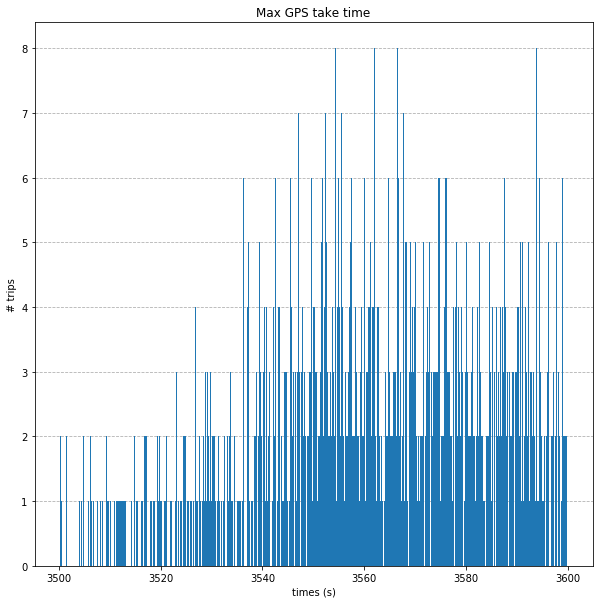

In [14]:
# This is our filter!
title = 'Max GPS take time'
print(title)
stat = filtered.take_time_max
display(stat.describe())
plt.figure(figsize=(10, 10))
#plots.log_scale(x=True, y=True)
plots.dist_chart(stat, title, 'times (s)')
plt.show()

In [15]:
title = 'GPS take time - st. dev.'
print(title)
stat = filtered.take_time_std
display(stat.describe())
plt.figure(figsize=(10, 10))
#plots.log_scale(x=True, y=True)
plots.dist_chart(stat, title, 'stddev time (seconds)')
plt.show()

GPS take time - st. dev.


count     997.000000
mean      458.471215
std       263.879676
min         0.000000
25%       298.566163
50%       399.645357
75%       523.617246
max      1789.013500
Name: take_time_std, dtype: float64

GPS take time skewness


count    997.000000
mean       9.551457
std        5.118674
min       -0.682006
25%        6.404879
50%        8.660253
75%       11.705007
max       39.165925
Name: take_time_skew, dtype: float64

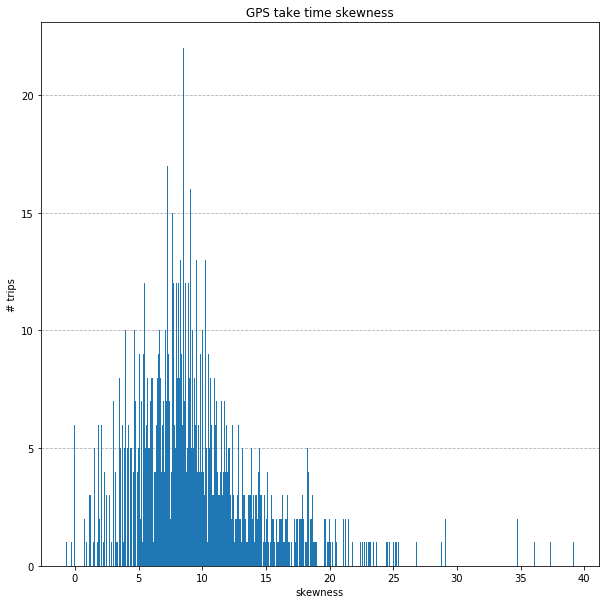

In [16]:
title = 'GPS take time skewness'
print(title)
stat = filtered.take_time_skew
display(stat.describe())
plt.figure(figsize=(10, 10))
#plots.log_scale(x=True, y=True)
plots.dist_chart(stat, title, 'skewness')
plt.show()

In [17]:
title = 'Travelled distances'
print(title)
stat = filtered.total_distance / 1000
display(stat.describe())
plt.figure(figsize=(10, 10))
#plots.log_scale(x=True, y=True)
plots.dist_chart(stat, title, 'distance (km)')
plt.show()

Travelled distances


count    997.000000
mean       1.854896
std        1.691266
min        0.050155
25%        0.771851
50%        1.284089
75%        2.414090
max        9.889037
Name: total_distance, dtype: float64

In [18]:
title = 'Mean distance between GPS takes'
print(title)
stat = filtered.mean_take_dist
display(stat.describe())
plt.figure(figsize=(10, 10))
#plots.log_scale(x=True, y=True)
plots.dist_chart(stat, title, 'distances (m)')
plt.show()

Mean distance between GPS takes


count     997.000000
mean       28.441304
std        87.138322
min         0.383387
25%        12.151526
50%        15.943644
75%        20.471932
max      1525.369630
Name: mean_take_dist, dtype: float64

Max distance between GPS takes


count     997.000000
mean      208.149759
std       577.659743
min         4.324904
25%        44.960781
50%        69.429900
75%       107.481537
max      5382.534768
Name: take_dist_max, dtype: float64

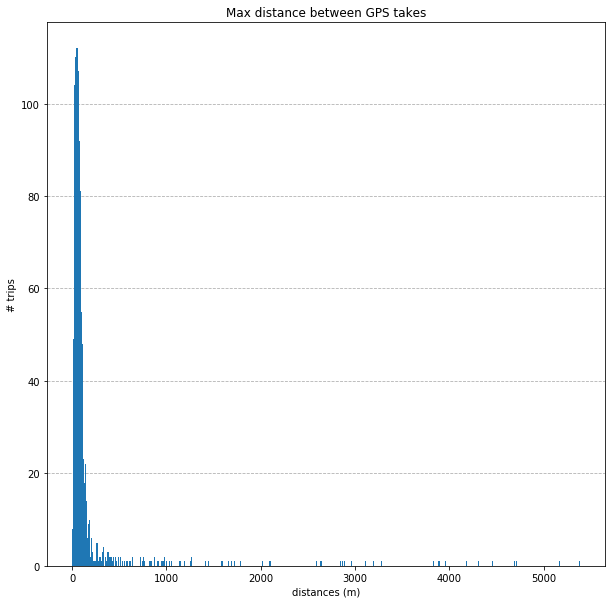

In [19]:
title = 'Max distance between GPS takes'
print(title)
stat = filtered.take_dist_max
display(stat.describe())
plt.figure(figsize=(10, 10))
#plots.log_scale(x=True, y=True)
plots.dist_chart(stat, title, 'distances (m)')
plt.show()

In [20]:
title = 'Distance between GPS takes - st. dev.'
print(title)
stat = filtered.take_dist_std
display(stat.describe())
plt.figure(figsize=(10, 10))
#plots.log_scale(x=True, y=True)
plots.dist_chart(stat, title, 'stddev distance (m)')
plt.show()

Distance between GPS takes - st. dev.


count     997.000000
mean       46.153807
std       169.784885
min         0.470396
25%         9.838292
50%        14.158553
75%        20.378294
max      2242.167135
Name: take_dist_std, dtype: float64

In [21]:
title = 'GPS take distance skewness'
print(title)
stat = filtered.take_dist_skew
display(stat.describe())
plt.figure(figsize=(10, 10))
#plots.log_scale(x=True, y=True)
plots.dist_chart(stat, title, 'skewness')
plt.show()

GPS take distance skewness


count    997.000000
mean       1.950623
std        2.413133
min       -1.232679
25%        0.727574
50%        1.331264
75%        2.243891
max       30.843732
Name: take_dist_skew, dtype: float64

Temporal analysis
* Per trip time

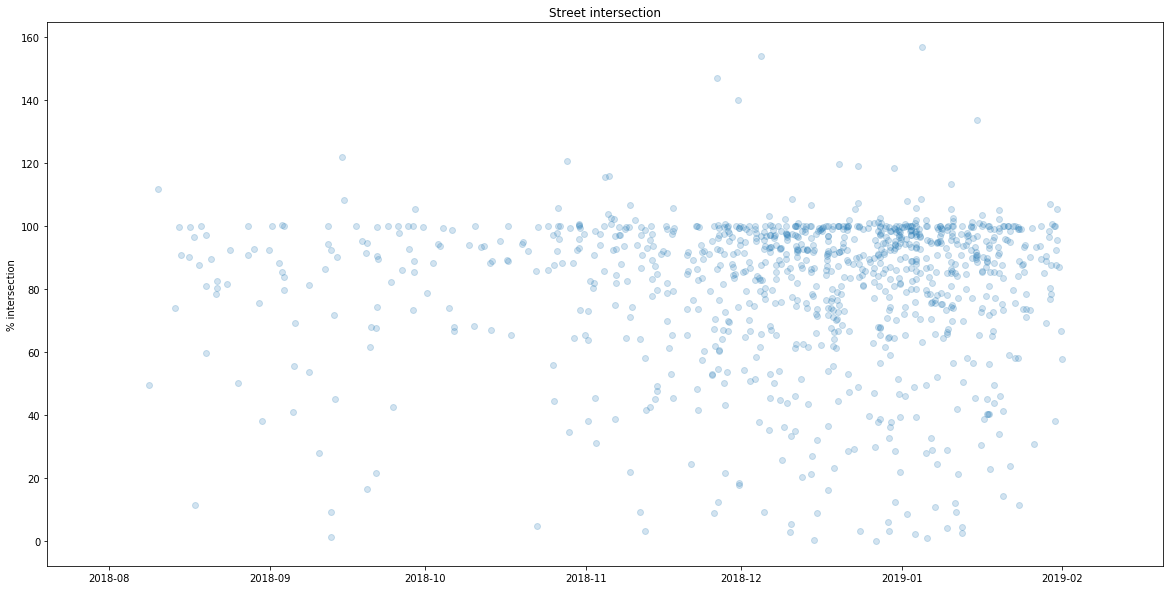

In [26]:
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(filtered.intersect_perc*100, 'Street intersection', '% intersection', filtered.start_time)
plt.show()

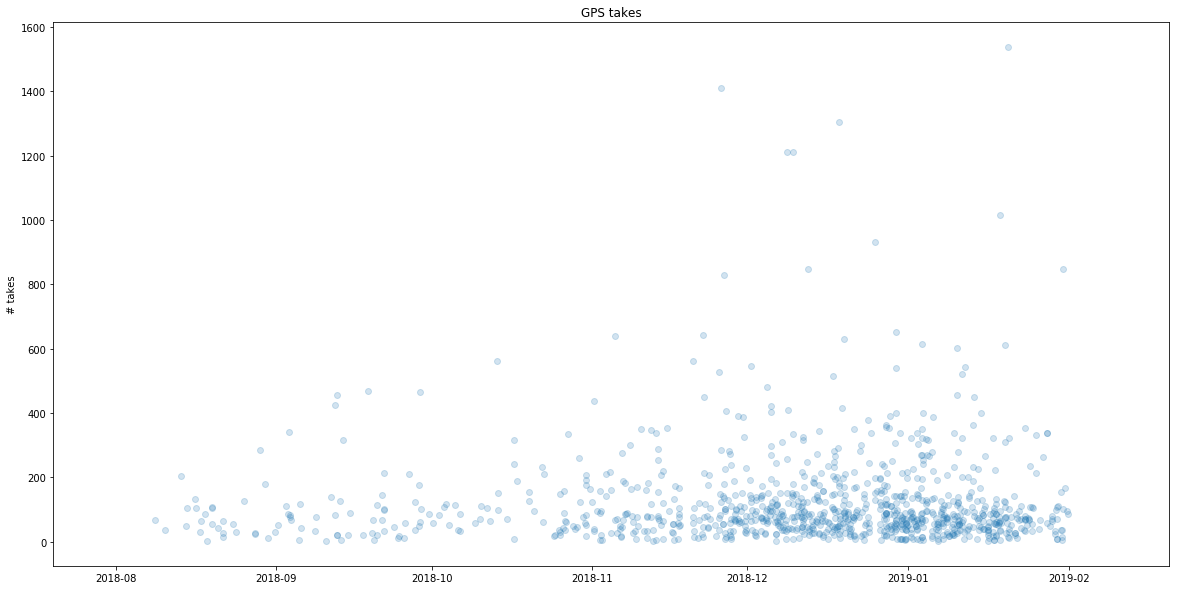

In [27]:
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(filtered.num_takes, 'GPS takes', '# takes', filtered.start_time)
plt.show()

In [28]:
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(filtered.total_duration/60, 'Trip durations', 'durations (m)', filtered.start_time)
plt.show()

In [29]:
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(filtered.mean_take_time, 'Time between GPS takes', 'mean take time (s)', filtered.start_time)
plt.show()

In [30]:
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(filtered.take_time_min, 'Min GPS take time', 'time (s)', filtered.start_time)
plt.show()

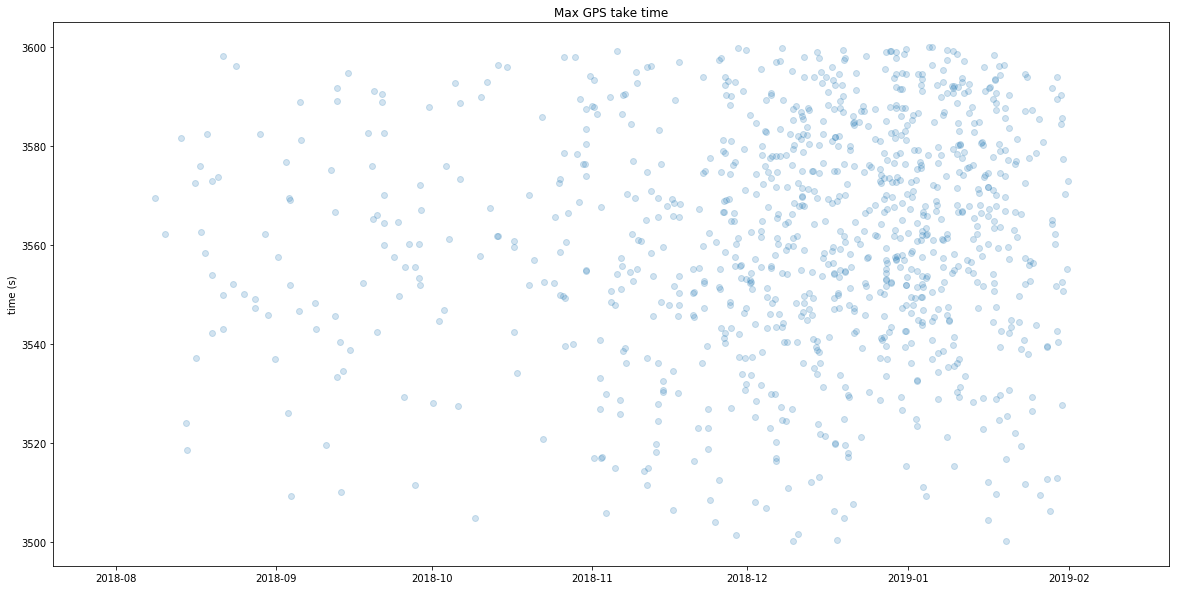

In [31]:
# Hi Mom, the filter is on tv!
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(filtered.take_time_max, 'Max GPS take time', 'time (s)', filtered.start_time)
plt.show()

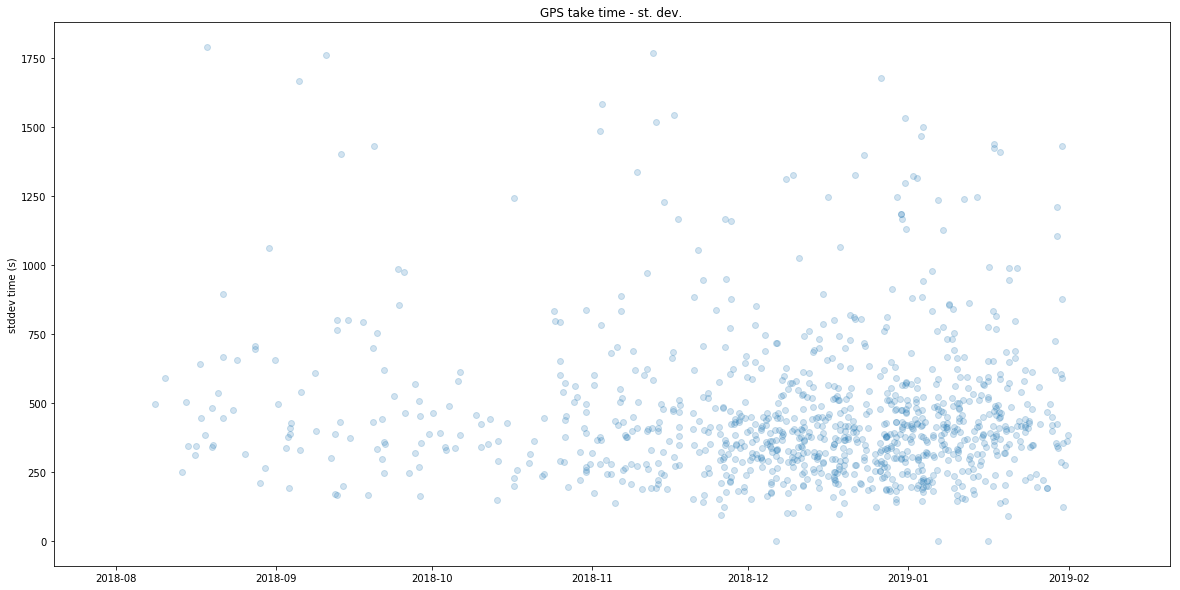

In [33]:
selected = filtered[filtered.take_time_std < 10000]
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(selected.take_time_std, 'GPS take time - st. dev.', 'stddev time (s)', selected.start_time)
plt.show()

In [34]:
selected = filtered[filtered.take_time_skew < 90]
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(selected.take_time_skew, 'GPS take time asymmetry', 'skewness', selected.start_time)
plt.show()

In [35]:
selected = filtered[filtered.total_distance < 1000000]
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(selected.total_distance/1000, 'Travelled distance', 'distance (km)', selected.start_time)
plt.show()

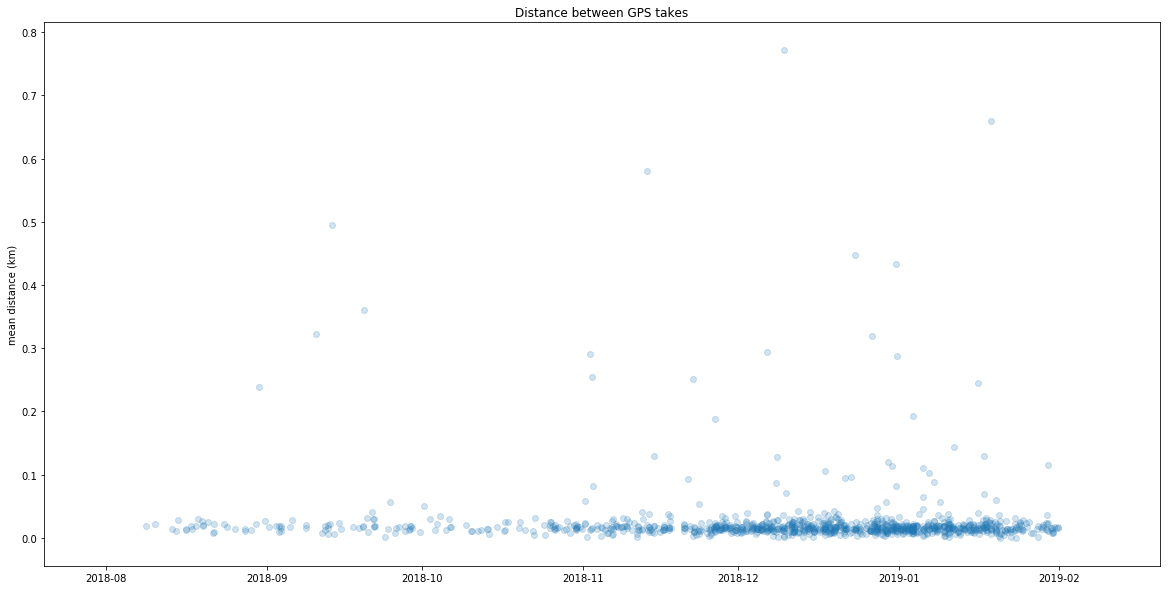

In [36]:
selected = filtered[filtered.mean_take_dist < 900]
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(selected.mean_take_dist/1000, 'Distance between GPS takes', 'mean distance (km)', selected.start_time)
plt.show()

In [37]:
selected = filtered[filtered.take_dist_max < 9000]
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(selected.take_dist_max, 'Max distance between GPS takes', 'distance (m)', selected.start_time)
plt.show()

In [38]:
selected = filtered[filtered.take_dist_std < 9000]
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(selected.take_dist_std, 'Distance between GPS takes - std. dev.', 'stddev distance (m)', 
                   selected.start_time)
plt.show()

In [39]:
selected = filtered[filtered.take_dist_skew < 60]
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(selected.take_dist_skew, 'Distance between GPS takes - asymmetry', 'skewness', selected.start_time)
plt.show()

When did each `bikeid` first appear?

In [40]:
bike_appearance = filtered.groupby('bikeid', as_index=False).agg({'start_time': 'min'})
bike_appearance.columns = ['bikeid', 'first_appearance']

New bikes

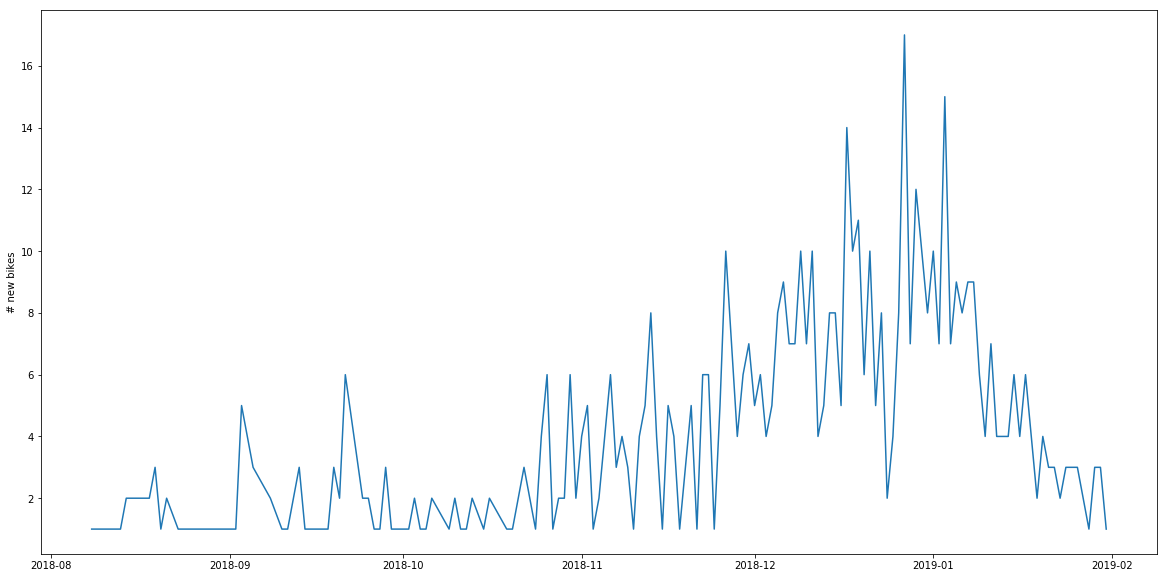

In [41]:
bike_appearance['appearance_date'] = bike_appearance.first_appearance.dt.to_period('d').dt.to_timestamp()
new_bikes_per_day = bike_appearance.groupby('appearance_date', as_index=False).agg({'bikeid': 'count'})
new_bikes_per_day.columns = ['date', 'new_bikes_count']
plt.figure(figsize=(20, 10))
plt.ylabel('# new bikes')
plt.plot(new_bikes_per_day.date, new_bikes_per_day.new_bikes_count)
plt.show()

Bike ages

In [42]:
bike_ages = filtered.merge(bike_appearance, on='bikeid')
bike_ages['age'] = (bike_ages.start_time - bike_ages.first_appearance).astype('timedelta64[h]') / 24

In [43]:
title = 'Bike ages'
print(title)
stat = bike_ages.age
display(stat.describe())
plots.dist_chart(stat, title, 'age (days)')

Bike ages


count    997.000000
mean      10.061184
std       26.206370
min        0.000000
25%        0.000000
50%        0.000000
75%        4.291667
max      156.791667
Name: age, dtype: float64

Relation between bike age and the variables

In [45]:
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(bike_ages.intersect_perc*100, 'Street intersection', '% intersection', bike_ages.age)
plt.show()

In [46]:
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(bike_ages.num_takes, 'GPS takes', '# takes', bike_ages.age)
plt.show()

In [47]:
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(bike_ages.total_duration/60, 'Trip durations', 'durations (m)', bike_ages.age)
plt.show()

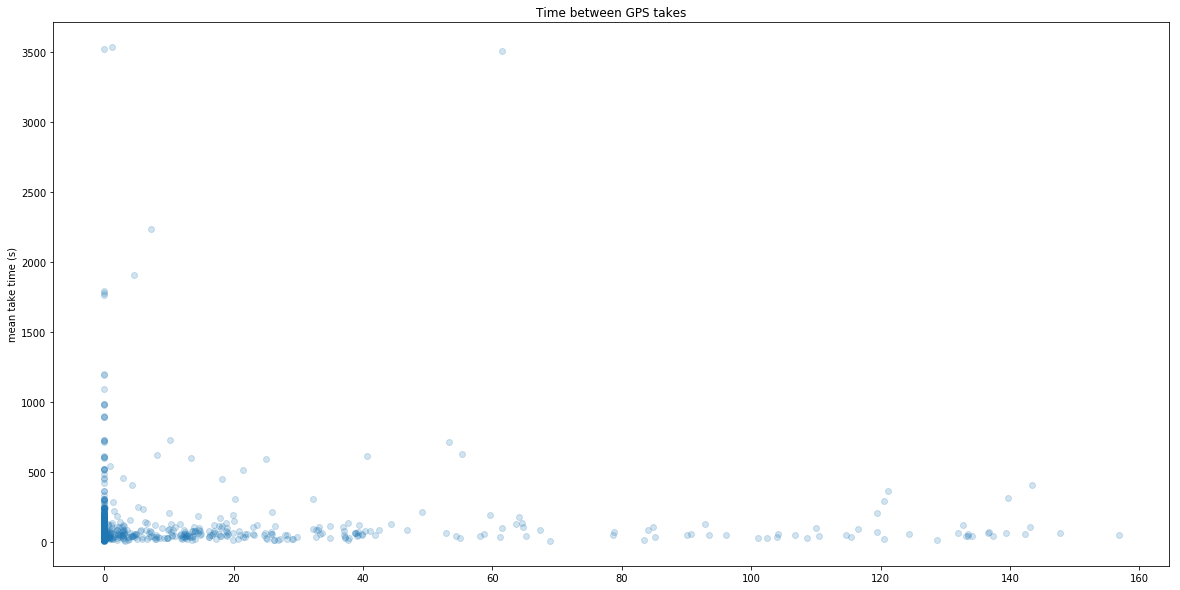

In [48]:
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(bike_ages.mean_take_time, 'Time between GPS takes', 'mean take time (s)', bike_ages.age)
plt.show()

In [49]:
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(bike_ages.take_time_min, 'Min GPS take time', 'time (s)', bike_ages.age)
plt.show()

In [50]:
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(bike_ages.take_time_max, 'Max GPS take time', 'time (s)', bike_ages.age)
plt.show()

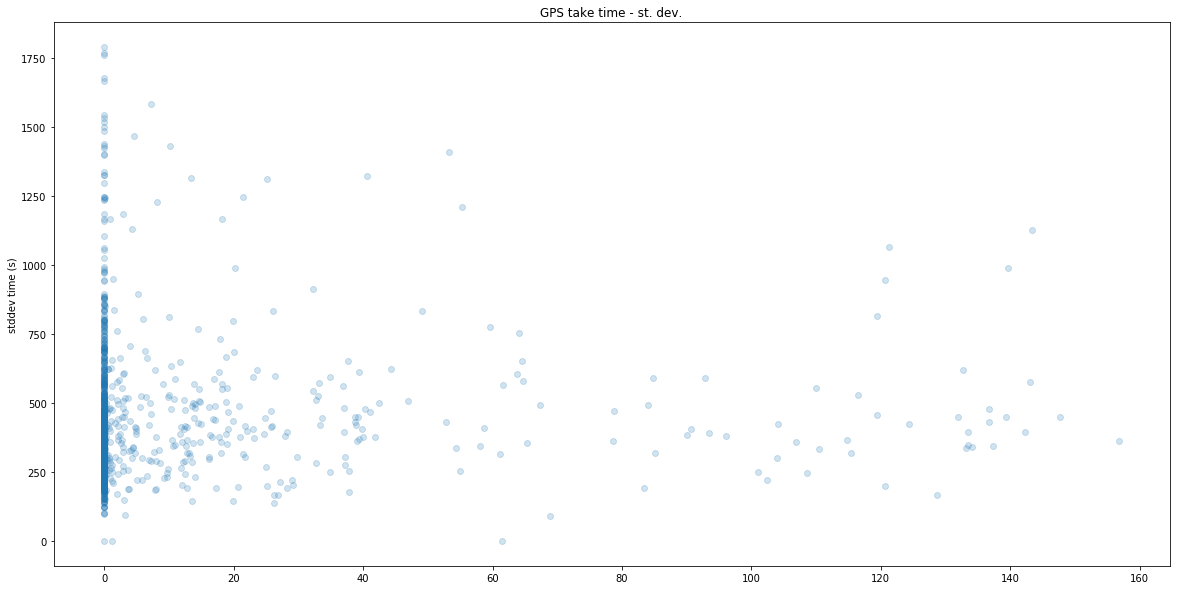

In [51]:
selected = bike_ages[bike_ages.take_time_std < 10000]
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(selected.take_time_std, 'GPS take time - st. dev.', 'stddev time (s)', selected.age)
plt.show()

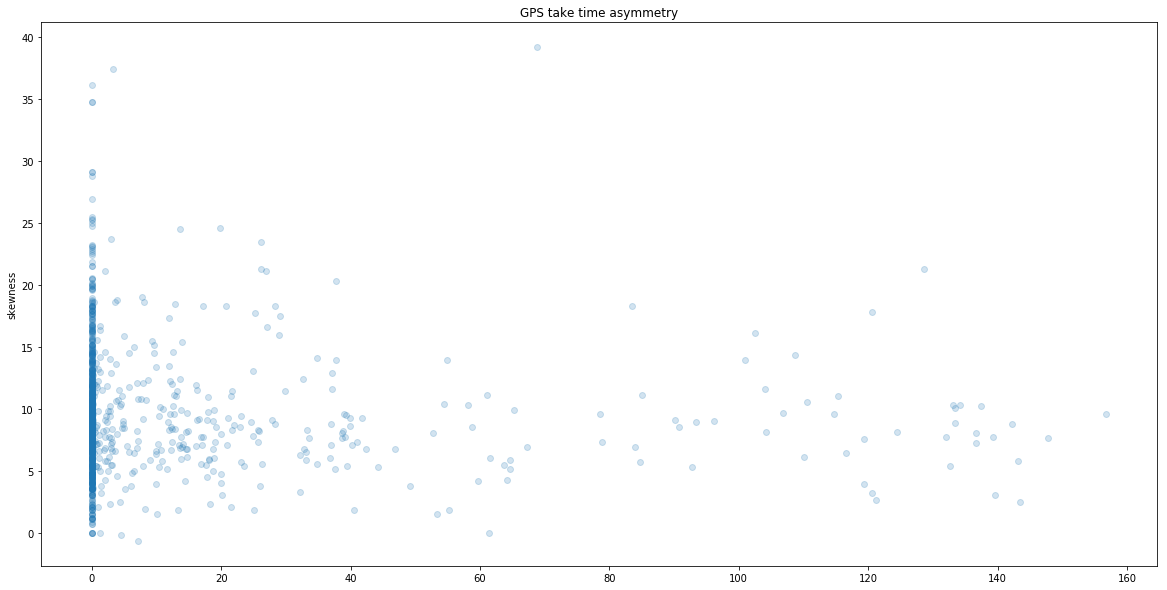

In [52]:
selected = bike_ages[bike_ages.take_time_skew < 90]
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(selected.take_time_skew, 'GPS take time asymmetry', 'skewness', selected.age)
plt.show()

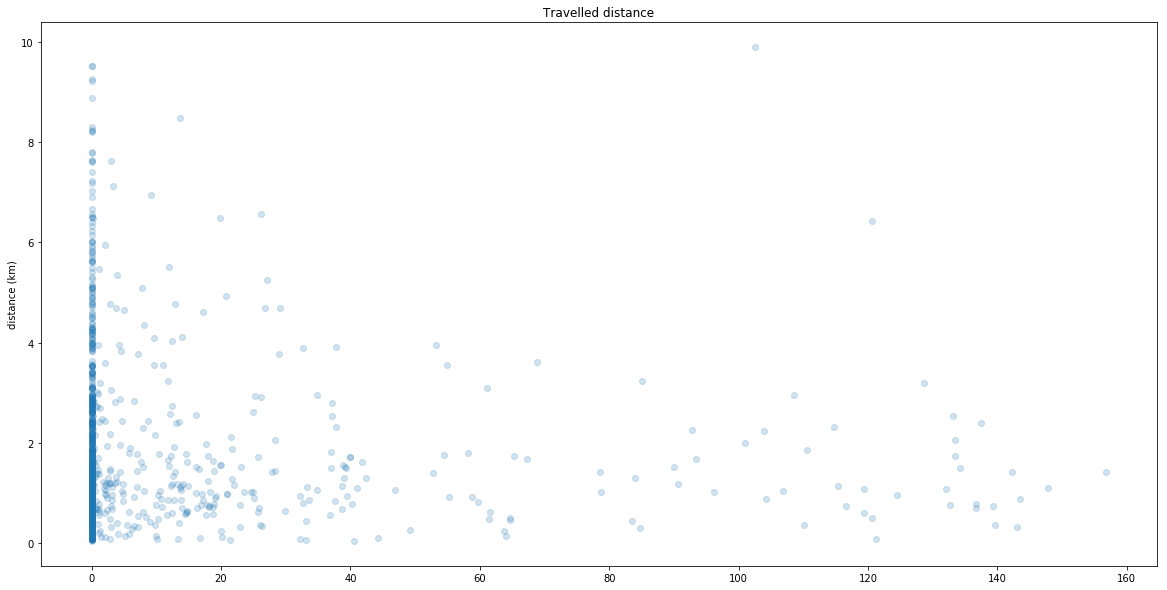

In [53]:
selected = bike_ages[bike_ages.total_distance < 1000000]
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(selected.total_distance/1000, 'Travelled distance', 'distance (km)', selected.age)
plt.show()

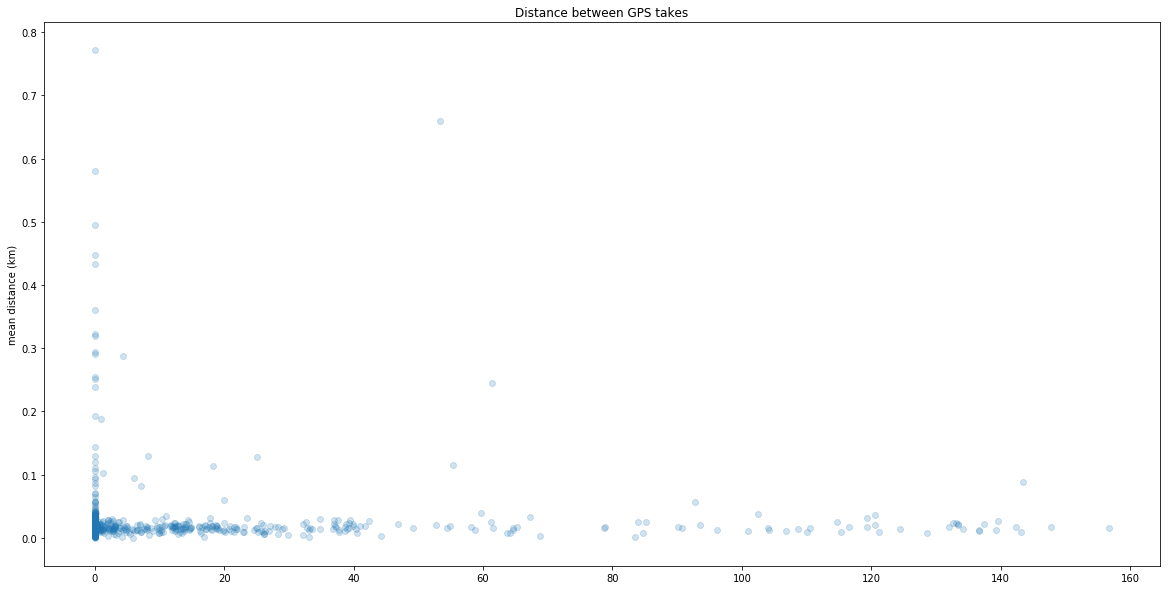

In [54]:
selected = bike_ages[bike_ages.mean_take_dist < 900]
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(selected.mean_take_dist/1000, 'Distance between GPS takes', 'mean distance (km)', selected.age)
plt.show()

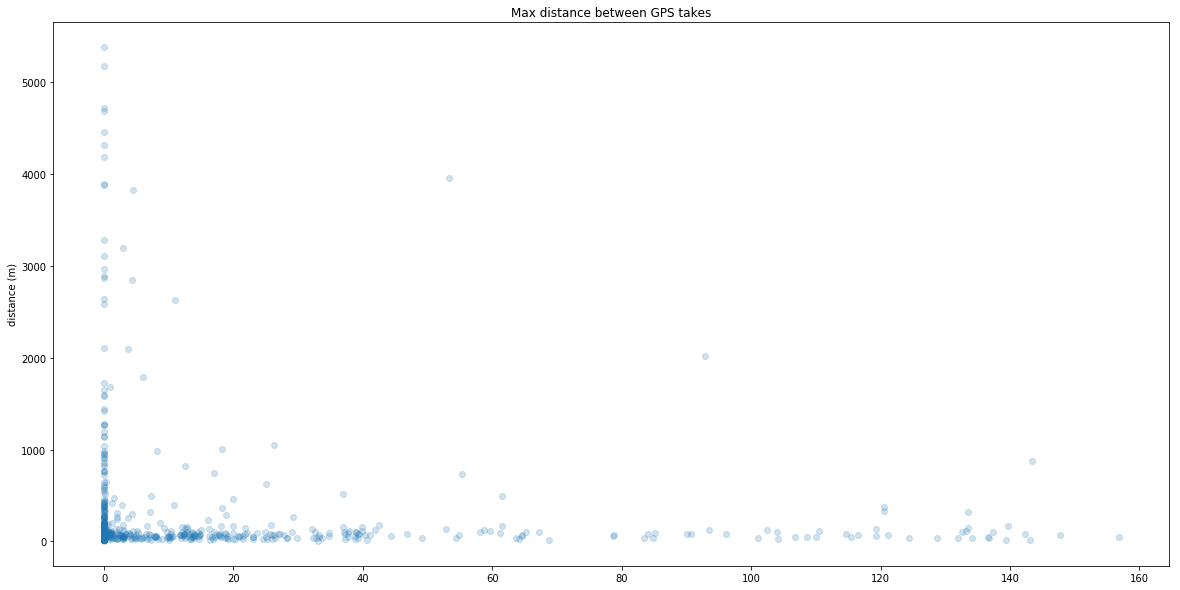

In [55]:
selected = bike_ages[bike_ages.take_dist_max < 9000]
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(selected.take_dist_max, 'Max distance between GPS takes', 'distance (m)', selected.age)
plt.show()

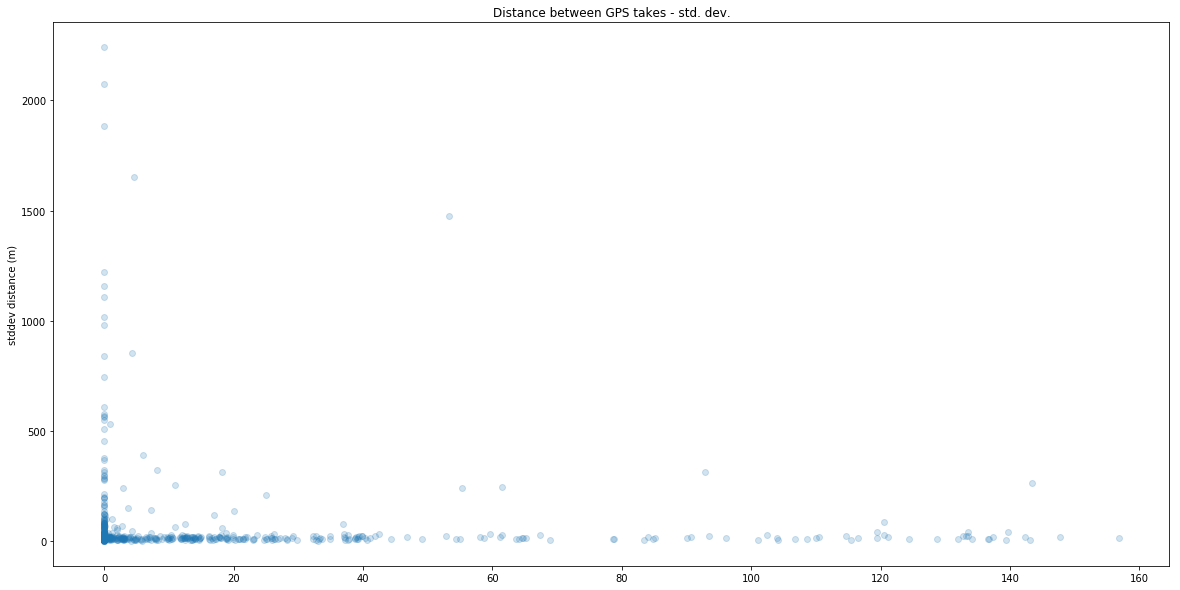

In [56]:
selected = bike_ages[bike_ages.take_dist_std < 9000]
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(selected.take_dist_std, 'Distance between GPS takes - std. dev.', 'stddev distance (m)', 
                   selected.age)
plt.show()

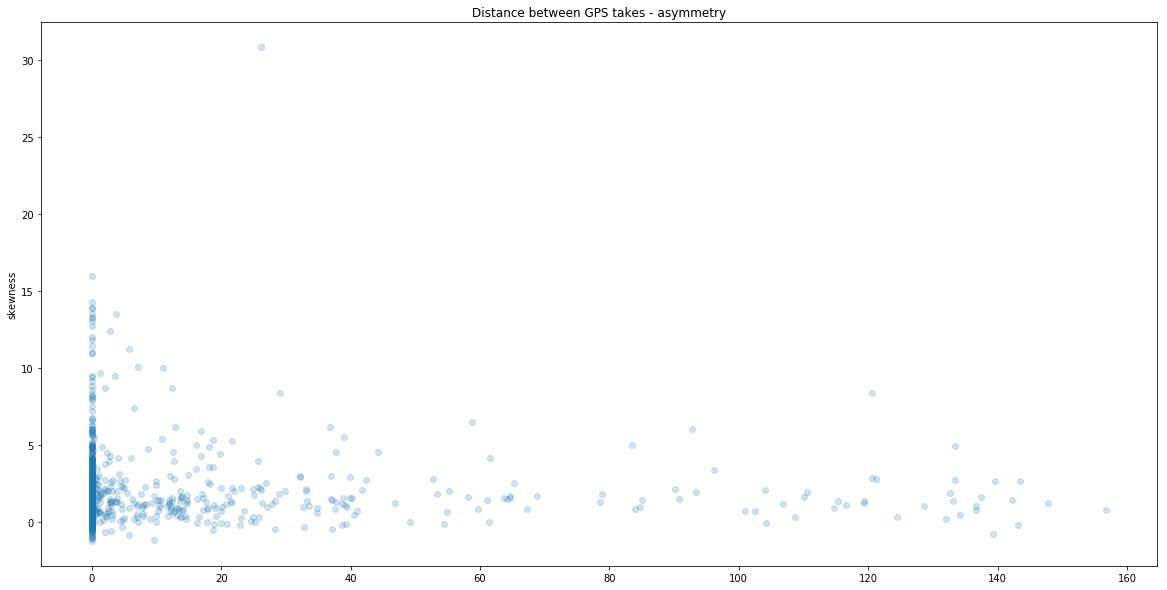

In [57]:
selected = bike_ages[bike_ages.take_dist_skew < 60]
plt.figure(figsize=(20, 10))
#plots.log_scale(y=True)
plots.time_scatter(selected.take_dist_skew, 'Distance between GPS takes - asymmetry', 'skewness', selected.age)
plt.show()